In [1]:
# synthetic population synthesis fits
# one i have a stellar population age, it corresponds to a max mass on main sequence
# that's how I get m2

# find way to assign stellar population age as a function of lookback time

# check colin's equation

In [2]:
import kcorrect.kcorrect
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')

In [3]:
import sncosmo

In [37]:
sncosmo.__version__

'2.9.0'

In [24]:
class GalaxySource(sncosmo.Source):
    _param_names = ['c1', 'c2', 'c3', 'c4', 'c5']
    param_names_latex = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    def __init__(self, mag_dict, obs_z):
                
        """
        mag_dict: keys are input passbands, values are tuples of magnitudes and uncertainty
        """
        
        self.name = 'Galaxy'
        self.version = 0.1
        self._phase = 0
        
        bands, responses = list(mag_dict.keys()), list(mag_dict.values())
        kc = kcorrect.kcorrect.Kcorrect(responses = bands)
        mags = [r[0] for r in responses]
        errs = [r[1] for r in responses]
        maggies, ivar = kcorrect.utils.sdss_asinh_to_maggies(mags, errs)
        coeffs = kc.fit_coeffs(redshift=obs_z, maggies=maggies, ivar = ivar)
        rf_mags = kc.absmag(redshift=obs_z, maggies=maggies, ivar=ivar, coeffs=coeffs)
        print(rf_mags)
        maggies, ivar = kcorrect.utils.sdss_asinh_to_maggies(rf_mags, errs)
        coeffs = kc.fit_coeffs(redshift=0, maggies=maggies, ivar = ivar)
        
        
        templates = kc.templates
        #templates.set_redshift(obs_z)
        self._wave = templates.restframe_wave # * (1. + obs_z)
        self.obs_z = obs_z
        self.kc = kc
        self.coeffs = coeffs
        self._parameters = coeffs
        self.templates = templates
        
    def _flux(self, phase, wave):
        default_wave = self._wave
        coeffs = self.coeffs
        temp_flux = self.templates.flux
        default_flux = coeffs.dot(temp_flux) # / (1. + self.obs_z) 
        rf_flux = default_flux 
        fill_errs = np.full(len(default_wave), 0.001)
        spectrum = sncosmo.Spectrum(default_wave, rf_flux, fill_errs)
        binned_spectrum = spectrum.rebin(wave)
        flux = binned_spectrum.flux
        return flux.reshape(1, len(flux))

In [25]:
at2018hyz = {'u_mag': 19.195, 'err_u': 0.034,
           'g_mag': 17.605, 'err_g': 0.005,
           'r_mag': 17.040, 'err_r': 0.005,
           'i_mag': 16.755, 'err_i': 0.005,
           'z_mag': 16.546, 'err_z': 0.0014,
            'z':  0.0457}

mag_dict = {'sdss_u0': (at2018hyz['u_mag'], at2018hyz['err_u']),
           'sdss_g0': (at2018hyz['g_mag'], at2018hyz['err_g']),
           'sdss_r0': (at2018hyz['r_mag'], at2018hyz['err_r']),
           'sdss_i0': (at2018hyz['i_mag'], at2018hyz['err_i']),
           'sdss_z0': (at2018hyz['z_mag'], at2018hyz['err_z'])}

gal = GalaxySource(mag_dict = mag_dict, obs_z = at2018hyz['z'])

[-17.6151119  -19.0693749  -19.65242706 -19.82983431 -20.07036986]


In [30]:
A = gal.coeffs.dot(gal.templates.flux)

In [27]:
kc = gal.kc

In [35]:
wave = gal._wave
wave = np.linspace(min(wave), max(wave), 80)
# flux = gal._flux(0, wave)[0, :]

In [36]:
%prun flux = gal._flux(0, wave)[0, :]

In [10]:
test_spec = sncosmo.Spectrum(wave, flux, np.full(len(wave), 0.000000000001))

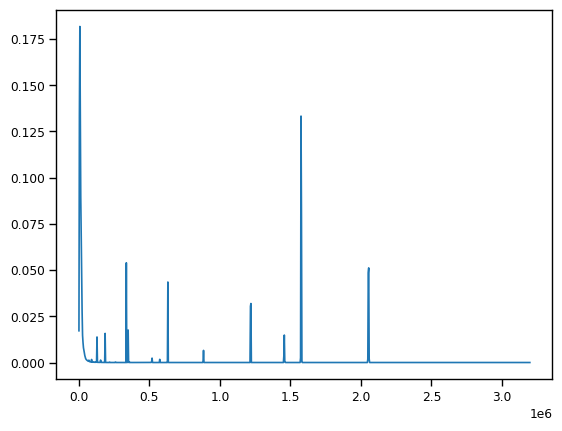

In [11]:
plt.plot(wave, flux)

In [38]:
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const
import sys
sys.path.append('../')
from scripts import tde_utils

In [39]:
wide_limits = {'f062': 26.4,
               'f087': 25.6, 
               'f106': 25.5,
               'f129': 25.4
              }


deep_limits = {'f106': 26.7,
               'f129': 26.6,
               'f158': 26.5,
               'f184': 26.7
              }

In [ ]:
from tqdm.notebook import tqdm

zs = np.linspace(0.1, 7.5, 24)

result_dict = {'f062': np.zeros(len(zs)), 
               'f087': np.zeros(len(zs)), 
               'f106': np.zeros(len(zs)),
               'f129': np.zeros(len(zs)),
               'f158': np.zeros(len(zs)),
               'f184': np.zeros(len(zs)),
               'f213': np.zeros(len(zs)),
               'f146': np.zeros(len(zs))
              }
tde_mags = {'f062': np.zeros(len(zs)), 
               'f087': np.zeros(len(zs)), 
               'f106': np.zeros(len(zs)),
               'f129': np.zeros(len(zs)),
               'f158': np.zeros(len(zs)),
               'f184': np.zeros(len(zs)),
               'f213': np.zeros(len(zs)),
               'f146': np.zeros(len(zs))
              }
gal_mags = {'f062': np.zeros(len(zs)), 
               'f087': np.zeros(len(zs)), 
               'f106': np.zeros(len(zs)),
               'f129': np.zeros(len(zs)),
               'f158': np.zeros(len(zs)),
               'f184': np.zeros(len(zs)),
               'f213': np.zeros(len(zs)),
               'f146': np.zeros(len(zs))
              }
snia_mags = {'f062': np.zeros(len(zs)), 
               'f087': np.zeros(len(zs)), 
               'f106': np.zeros(len(zs)),
               'f129': np.zeros(len(zs)),
               'f158': np.zeros(len(zs)),
               'f184': np.zeros(len(zs)),
               'f213': np.zeros(len(zs)),
               'f146': np.zeros(len(zs))
              }

qso_mags = {'f062': np.zeros(len(zs)), 
               'f087': np.zeros(len(zs)), 
               'f106': np.zeros(len(zs)),
               'f129': np.zeros(len(zs)),
               'f158': np.zeros(len(zs)),
               'f184': np.zeros(len(zs)),
               'f213': np.zeros(len(zs)),
               'f146': np.zeros(len(zs))
              }

# abs_r = kc_sdss.absmag(redshift = redshift, maggies = maggies, 
#                        ivar=ivar, coeffs = coeffs)[2]

filter_loop = tqdm(list(result_dict.keys()), total = len(list(result_dict.keys()))*len(zs))
qso_source = tde_utils.QSOSource(r_mag = -25.)

for roman_filter in filter_loop:
    print(roman_filter)
    for i, z in enumerate(zs):
    
        luminosity_distance = cosmo.luminosity_distance(z)
        
        # TDE Magnitudes
        source = tde_utils.BlackBodySource(30000)
        bb_model = sncosmo.Model(source=source)
        bb_model.set(z=z)

        filter_zstretched_mag = bb_model.bandmag(roman_filter, 'ab', 0)
        app_mag = filter_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
        tde_mags[roman_filter][i] = app_mag

        # Galaxy Magnitudes

        gal_model = sncosmo.Model(source=gal)
        gal_model.set(z=z)
        try:
            gal_zstretched_mag = gal_model.bandmag(roman_filter, 'ab', 0)
            app_mag = gal_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
            gal_mags[roman_filter][i] = app_mag
        except:
            gal_mags[roman_filter][i] = np.nan
        
        # SNe Ia Magnitudes

        snia_model = sncosmo.Model(source='salt2-extended')
        snia_model.set(z=z)
        snia_model.set(x1=0, c=0, x0= 1051627384124.3574, t0=0)
        try:
            snia_zstretched_mag = snia_model.bandmag(roman_filter, 'ab', 0)
            snia_app_mag = snia_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
            snia_mags[roman_filter][i] = snia_app_mag
        except Exception as e:
            #snia_mags[roman_filter].append(np.nan)
            print('simulating sn as blackbody')
            snia_scale = 1.718e-16
            snia_source = tde_utils.BlackBodySource(temperature=5500., scale=snia_scale)
            snia_model = sncosmo.Model(source=snia_source)
            snia_model.set(z=z)
            
            snia_zstretched_mag = snia_model.bandmag(roman_filter, 'ab', 0)
            snia_app_mag = snia_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
            snia_mags[roman_filter][i] = snia_app_mag
            
        # QSO Magnitudes
        
        qso_model = sncosmo.Model(source=qso_source)
        qso_model.set(z=z)
        try:
            qso_zstretched_mag = qso_model.bandmag(roman_filter, 'ab', 0)
            app_mag = qso_zstretched_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
            qso_mags[roman_filter][i] = app_mag
        except:
            qso_mags[roman_filter][i] = np.nan
            
        filter_loop.update()

  0%|          | 0/192 [00:00<?, ?it/s]

f062


In [ ]:
l_alpha = 1215.67 #angstrom

In [ ]:
# fig, axes = plt.subplots(nrows=len(result_dict.keys()), dpi = 200, 
#                          figsize = [6, 4*len(result_dict.keys())])

fig, ax = plt.subplots(dpi=300)

# lyman alpha
roman_filter='f184'
band = sncosmo.get_bandpass(roman_filter)
z_contam = (band.minwave() / l_alpha) - 1

ax.plot(zs, tde_mags[roman_filter], label = 'TDEs')
ax.plot(zs, gal_mags[roman_filter], label = 'Host Galaxies')
ax.plot(zs, snia_mags[roman_filter], label = 'SNe Ia')
#ax.plot(zs, qso_mags[roman_filter], label = 'Quasars')

xmin, xmax = ax.get_xlim()
ax.axvspan(z_contam, xmax, zorder = -1, alpha = 0.3, color = 'grey')

if roman_filter in wide_limits.keys():
    ax.axhline(wide_limits[roman_filter], c = 'k', ls = '--', label = 'HLTDS Wide Limit')
if roman_filter in deep_limits.keys():
    ax.axhline(deep_limits[roman_filter], c = 'k', ls = '-.', label = 'HLTDS Deep Limit')

ax.axhline(27.4, c = 'k', ls = ':', label = 'One Hour Point Source Limit')
ax.axhline(24.4, c = 'k', ls = 'solid', label = 'One Minute Point Source Limit')

ax.set_title(roman_filter)
ax.set_xlabel('z')
ax.set_ylabel('Magnitude')
ax.legend()
ymin, ymax = ax.get_ylim()
ax.set_ylim(np.min([ymax, 32]), ymin)
ax.set_xlim(min(zs), max(zs))

fig.suptitle('Roman Magnitudes vs Redshift', y = 0.995)
plt.tight_layout()
plt.savefig(f'../figures/f184_mag_vs_z.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=len(result_dict.keys()), dpi = 200, 
                         figsize = [6, 4*len(result_dict.keys())])
for i, roman_filter in enumerate(result_dict.keys()):
    
    ax = axes[i]
    
    # lyman alpha
    band = sncosmo.get_bandpass(roman_filter)
    z_contam = (band.minwave() / l_alpha) - 1
    
    ax.plot(zs, tde_mags[roman_filter], label = 'TDEs')
    ax.plot(zs, gal_mags[roman_filter], label = 'Host Galaxies')
    ax.plot(zs, snia_mags[roman_filter], label = 'SNe Ia')
    ax.plot(zs, qso_mags[roman_filter], label = 'Quasars')
    
    xmin, xmax = ax.get_xlim()
    ax.axvspan(z_contam, xmax, zorder = -1, alpha = 0.3, color = 'grey')
    
    if roman_filter in wide_limits.keys():
        ax.axhline(wide_limits[roman_filter], c = 'k', ls = '--', label = 'Roman Wide Limit')
    if roman_filter in deep_limits.keys():
        ax.axhline(deep_limits[roman_filter], c = 'k', ls = '-.', label = 'Roman Deep Limit')
    
    ax.set_title(roman_filter)
    ax.set_xlabel('z')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(np.min([ymax, 32]), ymin)
    ax.set_xlim(min(zs), max(zs))
    
fig.suptitle('Roman Magnitudes vs Redshift', y = 0.995)
plt.tight_layout()
plt.savefig(f'../figures/mag_vs_z_roman.pdf', dpi = 300)
print(fig.get_size_inches())
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi = 200, 
                         figsize = [6*2, 4*4])
for i, roman_filter in enumerate(result_dict.keys()):
    
    ax = axes.flatten()[i]
    
    # lyman alpha
    band = sncosmo.get_bandpass(roman_filter)
    z_contam = (band.minwave() / l_alpha) - 1
    
    ax.plot(zs, tde_mags[roman_filter], label = 'TDEs')
    ax.plot(zs, gal_mags[roman_filter], label = 'Host Galaxies')
    ax.plot(zs, snia_mags[roman_filter], label = 'SNe Ia')
    ax.plot(zs, qso_mags[roman_filter], label = 'Quasars')
    
    xmin, xmax = ax.get_xlim()
    ax.axvspan(z_contam, xmax, zorder = -1, alpha = 0.3, color = 'grey')
    
    if roman_filter in wide_limits.keys():
        ax.axhline(wide_limits[roman_filter], c = 'k', ls = '--', label = 'Roman Wide Limit')
    if roman_filter in deep_limits.keys():
        ax.axhline(deep_limits[roman_filter], c = 'k', ls = '-.', label = 'Roman Deep Limit')
    
    ax.set_title(roman_filter)
    ax.set_xlabel('z')
    ax.set_ylabel('Magnitude')
    ax.legend()
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(np.min([ymax, 32]), ymin)
    ax.set_xlim(min(zs), max(zs))
    
fig.suptitle('Roman Magnitudes vs Redshift', y = 0.995)
plt.tight_layout()
plt.savefig(f'../figures/mag_vs_z_roman_grid.pdf', dpi = 300)
print(fig.get_size_inches())
plt.show()

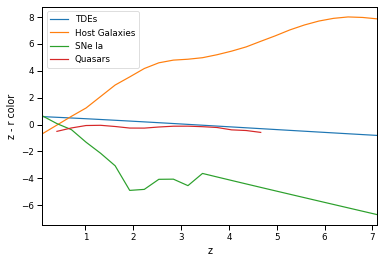

In [19]:
# for roman_filter in result_dict.keys():

# lyman alpha
band = sncosmo.get_bandpass(roman_filter)
z_contam = (band.minwave() / l_alpha) - 1

plt.plot(zs, tde_mags['f087'] - tde_mags['f062'], label = 'TDEs')
plt.plot(zs, gal_mags['f087'] - tde_mags['f062'], label = 'Host Galaxies')
plt.plot(zs, snia_mags['f087'] - snia_mags['f062'], label = 'SNe Ia')
plt.plot(zs, qso_mags['f087'] - qso_mags['f062'], label = 'Quasars')


ax = plt.gca()
xmin, xmax = ax.get_xlim()
#ax.axvspan(z_contam, xmax, zorder = -1, alpha = 0.3, color = 'grey')

#     if roman_filter in wide_limits.keys():
#         plt.axhline(wide_limits[roman_filter], c = 'k', ls = '--', label = 'Roman Wide Limit')
#     if roman_filter in deep_limits.keys():
#         plt.axhline(deep_limits[roman_filter], c = 'k', ls = '-.', label = 'Roman Deep Limit')

plt.xlabel('z')
plt.ylabel('z - r color')
plt.legend()
ymin, ymax = ax.get_ylim()
# ax.set_ylim(np.min([ymax, 32]), ymin)
ax.set_xlim(min(zs), max(zs))
plt.savefig(f'../figures/color_vs_z.png', dpi = 300)
plt.show()

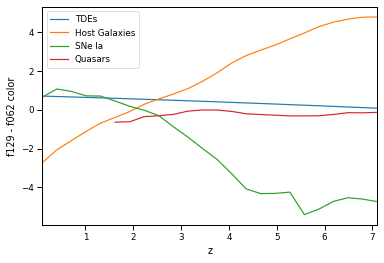

In [23]:
# for roman_filter in result_dict.keys():

# lyman alpha
band = sncosmo.get_bandpass(roman_filter)
z_contam = (band.minwave() / l_alpha) - 1

plt.plot(zs, tde_mags['f184'] - tde_mags['f129'], label = 'TDEs')
plt.plot(zs, gal_mags['f184'] - tde_mags['f129'], label = 'Host Galaxies')
plt.plot(zs, snia_mags['f184'] - snia_mags['f129'], label = 'SNe Ia')
plt.plot(zs, qso_mags['f184'] - qso_mags['f129'], label = 'Quasars')


ax = plt.gca()
xmin, xmax = ax.get_xlim()
#ax.axvspan(z_contam, xmax, zorder = -1, alpha = 0.3, color = 'grey')

#     if roman_filter in wide_limits.keys():
#         plt.axhline(wide_limits[roman_filter], c = 'k', ls = '--', label = 'Roman Wide Limit')
#     if roman_filter in deep_limits.keys():
#         plt.axhline(deep_limits[roman_filter], c = 'k', ls = '-.', label = 'Roman Deep Limit')

plt.xlabel('z')
plt.ylabel('f129 - f062 color')
plt.legend()
ymin, ymax = ax.get_ylim()
# ax.set_ylim(np.min([ymax, 32]), ymin)
ax.set_xlim(min(zs), max(zs))
#plt.savefig(f'../figures/color_vs_z.png', dpi = 300)
plt.show()